In [165]:
# Import libraries here
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg

In [166]:
df = pd.read_csv('https://raw.githubusercontent.com/bahategar/Forecasting-Electricity-Production/main/Electric_Production.csv')
df.head()

,DATE,IPG2211A2N
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151


In [167]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DATE        397 non-null    object 
 1   IPG2211A2N  397 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.3+ KB


In [168]:
df.head()

,DATE,IPG2211A2N
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151


In [169]:
df.rename(columns={'DATE':'date', 'IPG2211A2N': 'production'}, inplace=True)

In [170]:
# Change format date
import datetime
dt = list()
for date in df.date :
  dt.append(datetime.datetime.strptime(date, '%m/%d/%Y').strftime('%Y-%m-%d'))

In [171]:
df['date'] = dt
df['date'] = df['date'].astype('datetime64[ns]')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        397 non-null    datetime64[ns]
 1   production  397 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 6.3 KB


In [172]:
df.head()

,date,production
0,1985-01-01,72.5052
1,1985-02-01,70.6720
2,1985-03-01,62.4502
3,1985-04-01,57.4714
4,1985-05-01,55.3151


# Exploratory Data Analysis

In [173]:
y = df[df.columns[-1]]
y.rename(index=df.date, inplace=True)
y

1985-01-01     72.5052
1985-02-01     70.6720
1985-03-01     62.4502
1985-04-01     57.4714
1985-05-01     55.3151
                ...   
2017-09-01     98.6154
2017-10-01     93.6137
2017-11-01     97.3359
2017-12-01    114.7212
2018-01-01    129.4048
Name: production, Length: 397, dtype: float64

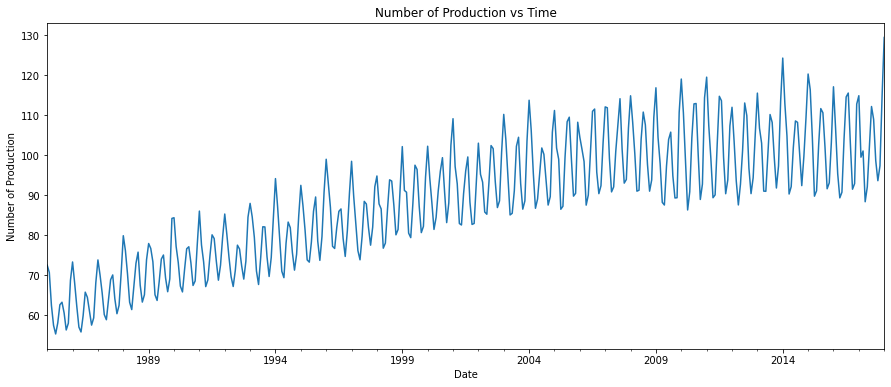

In [174]:
fig, ax = plt.subplots(figsize=(15, 6))
y.plot(ax=ax)
plt.ylabel('Number of Production')
plt.xlabel('Date')
plt.title('Number of Production vs Time');

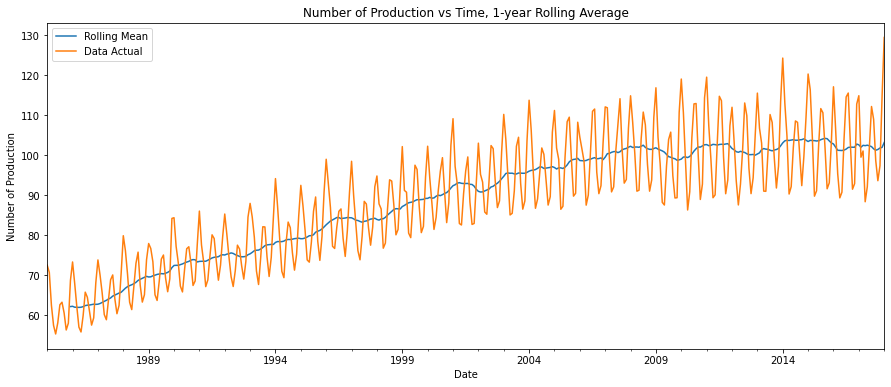

In [175]:
fig, ax = plt.subplots(figsize=(15, 6))
y.rolling(12).mean().plot(ax=ax, label='Rolling Mean')
y.plot(ax=ax, label='Data Actual')
plt.ylabel('Number of Production')
plt.xlabel('Date')
plt.title('Number of Production vs Time, 1-year Rolling Average')
plt.legend();

# ACF and PACF 

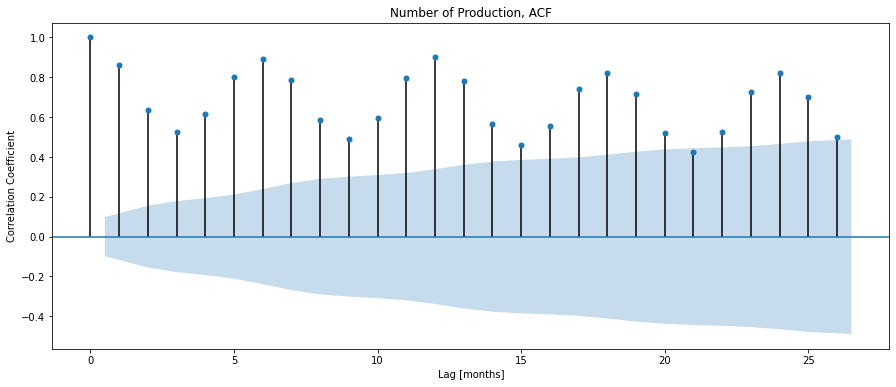

In [176]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y, ax=ax)
plt.ylabel('Correlation Coefficient')
plt.xlabel('Lag [months]')
plt.title('Number of Production, ACF')
plt.show()

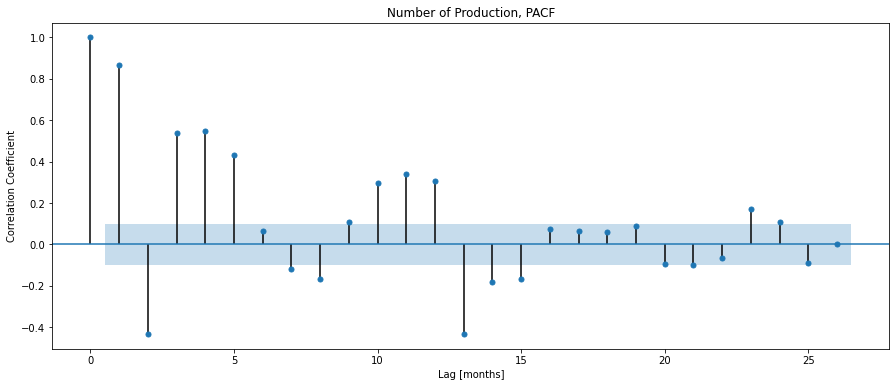

In [177]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(y, ax=ax)
plt.ylabel('Correlation Coefficient')
plt.xlabel('Lag [months]')
plt.title('Number of Production, PACF')
plt.show()


# Build Model

In [178]:
cutoff_test = int(0.9 * len(y))
y_train = y[:cutoff_test]
y_test = y[cutoff_test:]
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (357,)
y_test shape: (40,)


In [179]:
y_train_mean = y_train.mean()
y_pred_baseline = y_train_mean + y_train * 0
mae_baseline = mean_absolute_error(y_pred_baseline, y_train)

print("Mean P2 Reading:", y_train_mean)
print("Baseline MAE:", mae_baseline)

Mean P2 Reading: 87.25030924369749
Baseline MAE: 12.392397599039613


In [180]:
p_params = range(1, 31)
maes = []
for p in p_params:
    model = AutoReg(y_train, lags=p).fit()
    y_pred = model.predict().dropna()
    
    mae = mean_absolute_error(y_train.iloc[p:], y_pred)
    maes.append(mae)
    pass
mae_series = pd.Series(maes, name="mae", index=p_params)
mae_series.head()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/ar_model.py:252: FutureWarning:

The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/ar_model.py:252: FutureWarning:

The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old name

1    6.143230
2    5.303873
3    3.768281
4    3.166577
5    2.930270
Name: mae, dtype: float64

In [181]:
best_p = list(mae_series.values).index(mae_series.min())
best_model = AutoReg(y_train, lags=best_p).fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/ar_model.py:252: FutureWarning:

The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.



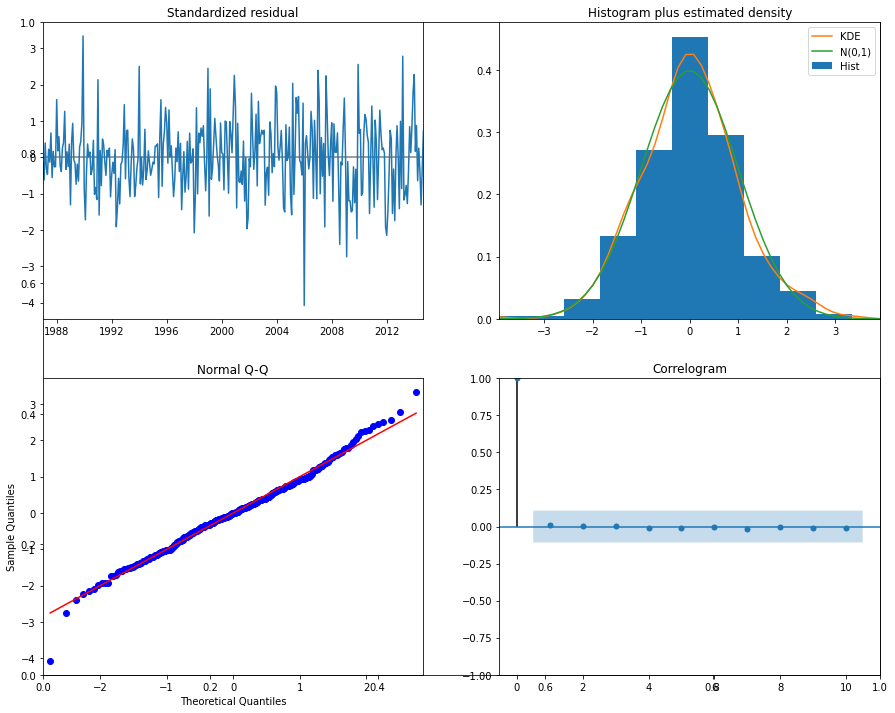

In [182]:
fig, ax = plt.subplots(figsize=(15, 12))
best_model.plot_diagnostics(fig=fig);

In [183]:
y_pred_wfv = pd.Series(dtype='float64')
history = y_train.copy()
for i in range(len(y_test)):
    model = AutoReg(history, lags=best_p).fit()
    next_pred = model.forecast()
    y_pred_wfv = y_pred_wfv.append(next_pred)
    history = history.append(y_test[next_pred.index])
    #pass
y_pred_wfv.name = "prediction"
y_pred_wfv.index.name = "timestamp"
y_pred_wfv.head()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/ar_model.py:252: FutureWarning:

The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/deterministic.py:152: UserWarning:

Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was 

timestamp
2014-10-01     93.121539
2014-11-01     97.823195
2014-12-01    112.436603
2015-01-01    118.291823
2015-02-01    112.108920
Freq: MS, Name: prediction, dtype: float64

In [184]:
df_pred_test = pd.DataFrame({'data actual':y_test, 'model':y_pred_wfv})
fig = px.line(df_pred_test)
fig.update_layout(
    xaxis_title="Date",
    yaxis_title="Production",
)